In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import plotly.express as px
from IPython.display import display as ds
#from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import style
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go

# Preprocesado y modelado
# ==============================================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn import tree

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
import os
import warnings
warnings.filterwarnings("ignore")
import gspread
from google.colab import auth
from google.auth import default

# Seccion 2: Motar drive y Cargar datos

In [ ]:
#esta opcion se modifico para que cargue de manera mas automatica sobre el google sheet
#from google.colab import drive
#drive.mount('/content/drive')
#delitos_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos/Trabajo final/delitos_2022.csv', low_memory=False)
#df_delitos_22= delitos_2022.copy()

# Authenticate and authorize access to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet using its URL
# Replace 'your_spreadsheet_id' with the actual ID from the URL
spreadsheet_id = '1HHdDkTsdp0m_1VZXwG7PF2Uzch_p4b9epljiTG9iRgg'
sheet = gc.open_by_key(spreadsheet_id).sheet1

# Read the data from the sheet into a Pandas DataFrame
delitos_2022 = pd.DataFrame(sheet.get_all_records())

df_delitos_22= delitos_2022.copy()
df_delitos_22.head()

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad
0,1,2022,OCTUBRE,VIERNES,2022-10-14,3,Robo,Robo total,NO,NO,CHACARITA,15,-34.584136,-58.454704,1
1,2,2022,OCTUBRE,JUEVES,2022-10-27,5,Robo,Robo total,NO,NO,BARRACAS,4,-34.645043,-58.373194,1
2,3,2022,NOVIEMBRE,MARTES,2022-11-29,0,Robo,Robo total,NO,NO,CHACARITA,15,-34.589982,-58.446471,1
3,4,2022,NOVIEMBRE,LUNES,2022-11-28,0,Robo,Robo total,NO,NO,CHACARITA,15,-34.58832,-58.441232,1
4,5,2022,NOVIEMBRE,MIERCOLES,2022-11-30,3,Robo,Robo total,NO,NO,RECOLETA,2,-34.596748,-58.413609,1


# Seccion 3: Exploratorios

## Informacion del dataset:

In [ ]:
#df_delitos_22.describe()
#df_delitos_22.describe(include="all")
#df_delitos_22.columns
df_delitos_22.info()
#df_delitos_22.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140918 entries, 0 to 140917
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id-mapa   140918 non-null  int64 
 1   anio      140918 non-null  int64 
 2   mes       140918 non-null  object
 3   dia       140918 non-null  object
 4   fecha     140918 non-null  object
 5   franja    140918 non-null  object
 6   tipo      140918 non-null  object
 7   subtipo   140918 non-null  object
 8   uso_arma  140918 non-null  object
 9   uso_moto  140918 non-null  object
 10  barrio    140918 non-null  object
 11  comuna    140918 non-null  object
 12  latitud   140918 non-null  object
 13  longitud  140918 non-null  object
 14  cantidad  140918 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 16.1+ MB


## Determinamos si el dataset posee valores nulos

In [ ]:
df_temp = df_delitos_22.isna().sum().sort_values()
df_temp[df_temp>0]

Series([], dtype: int64)

Nos centramos en analizar la existencia de datos donde no podamos llegar a determinar la ubicaion del delito

In [ ]:
#df_delitos_22[(df_delitos_22['barrio'].isna()) & (df_delitos_22['latitud'].isna()) & (df_delitos_22['longitud'].isna())]

Los mismos se eliminaran ya que no aportan informacion

In [ ]:
df_delitos_22.drop(df_delitos_22[(df_delitos_22['comuna'].isna())].index, inplace=True)

## Analizamos los datos de las columnas cantidad e id-mapa:


In [ ]:
df_delitos_22.cantidad.value_counts()

cantidad
1    140918
Name: count, dtype: int64

In [ ]:
df_delitos_22['id-mapa'].value_counts()

id-mapa
1          1
93949      1
93943      1
93944      1
93945      1
          ..
46967      1
46966      1
46965      1
46964      1
1114498    1
Name: count, Length: 140918, dtype: int64

Se elimnaron las columnas por no poseer informacion relevante

In [ ]:
df_delitos_22.drop(columns=['id-mapa','cantidad'],inplace=True)

Las columnas Latitud y Longitud se concatenan para dar origen a una dato geo posicional

In [ ]:
df_delitos_22["geo"]= df_delitos_22["latitud"].astype(str) + "," + df_delitos_22["longitud"].astype(str)
df_delitos_22.drop(columns=["latitud","longitud"],inplace=True)

In [ ]:
df_delitos_22

,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,geo
0,2022,OCTUBRE,VIERNES,2022-10-14,3,Robo,Robo total,NO,NO,CHACARITA,15,"-34.584136,-58.454704"
1,2022,OCTUBRE,JUEVES,2022-10-27,5,Robo,Robo total,NO,NO,BARRACAS,4,"-34.645043,-58.373194"
2,2022,NOVIEMBRE,MARTES,2022-11-29,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.589982,-58.446471"
3,2022,NOVIEMBRE,LUNES,2022-11-28,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.58832,-58.441232"
4,2022,NOVIEMBRE,MIERCOLES,2022-11-30,3,Robo,Robo total,NO,NO,RECOLETA,2,"-34.596748,-58.413609"
...,...,...,...,...,...,...,...,...,...,...,...,...
140913,2022,DICIEMBRE,JUEVES,2022-12-15,19,Vialidad,Muertes por siniestros viales,NO,NO,CHACARITA,15,"-34.585065,-58.459021"
140914,2022,DICIEMBRE,VIERNES,2022-12-16,13,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.63524,-58.487609"
140915,2022,DICIEMBRE,JUEVES,2022-12-22,11,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.638974,-58.482881"
140916,2022,DICIEMBRE,VIERNES,2022-12-30,18,Vialidad,Muertes por siniestros viales,NO,NO,PARQUE AVELLANEDA,9,"-34.652681,-58.481979"


Las variables que poseemos:

In [ ]:
df_delitos_22.columns

Index(['anio', 'mes', 'dia', 'fecha', 'franja', 'tipo', 'subtipo', 'uso_arma',
       'uso_moto', 'barrio', 'comuna', 'geo'],
      dtype='object')

**Copia de DataFrame

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

# Assuming 'df_delitos_22' is your original DataFrame
data = df_delitos_22.copy()

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Copiar el conjunto de datos en otro DataFrame de Pandas
data = df_delitos_22.copy()
data

,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,geo
0,2022,OCTUBRE,VIERNES,2022-10-14,3,Robo,Robo total,NO,NO,CHACARITA,15,"-34.584136,-58.454704"
1,2022,OCTUBRE,JUEVES,2022-10-27,5,Robo,Robo total,NO,NO,BARRACAS,4,"-34.645043,-58.373194"
2,2022,NOVIEMBRE,MARTES,2022-11-29,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.589982,-58.446471"
3,2022,NOVIEMBRE,LUNES,2022-11-28,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.58832,-58.441232"
4,2022,NOVIEMBRE,MIERCOLES,2022-11-30,3,Robo,Robo total,NO,NO,RECOLETA,2,"-34.596748,-58.413609"
...,...,...,...,...,...,...,...,...,...,...,...,...
140913,2022,DICIEMBRE,JUEVES,2022-12-15,19,Vialidad,Muertes por siniestros viales,NO,NO,CHACARITA,15,"-34.585065,-58.459021"
140914,2022,DICIEMBRE,VIERNES,2022-12-16,13,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.63524,-58.487609"
140915,2022,DICIEMBRE,JUEVES,2022-12-22,11,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.638974,-58.482881"
140916,2022,DICIEMBRE,VIERNES,2022-12-30,18,Vialidad,Muertes por siniestros viales,NO,NO,PARQUE AVELLANEDA,9,"-34.652681,-58.481979"


In [ ]:
data.uso_moto.value_counts()

uso_moto
NO    135854
SI      5064
Name: count, dtype: int64

In [ ]:
data.uso_arma.value_counts()

uso_arma
NO    132252
SI      8666
Name: count, dtype: int64

**Cada feature lo analizaremos con mayor detalle las features comuna y barrio que eran las que tenian valores nulos:**

In [ ]:
data.barrio.isnull().sum()

0

In [ ]:
data.comuna.isnull().sum()

0

In [ ]:
data[(data['comuna'].isna()) & (data['barrio'].isna())]

,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,geo


In [ ]:
# Eliminamos las filas que tienen registros nulos en la comuna, por ende en barrio, latitud y longitud
data.drop(data[data['comuna'].isna()].index)

,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,geo
0,2022,OCTUBRE,VIERNES,2022-10-14,3,Robo,Robo total,NO,NO,CHACARITA,15,"-34.584136,-58.454704"
1,2022,OCTUBRE,JUEVES,2022-10-27,5,Robo,Robo total,NO,NO,BARRACAS,4,"-34.645043,-58.373194"
2,2022,NOVIEMBRE,MARTES,2022-11-29,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.589982,-58.446471"
3,2022,NOVIEMBRE,LUNES,2022-11-28,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.58832,-58.441232"
4,2022,NOVIEMBRE,MIERCOLES,2022-11-30,3,Robo,Robo total,NO,NO,RECOLETA,2,"-34.596748,-58.413609"
...,...,...,...,...,...,...,...,...,...,...,...,...
140913,2022,DICIEMBRE,JUEVES,2022-12-15,19,Vialidad,Muertes por siniestros viales,NO,NO,CHACARITA,15,"-34.585065,-58.459021"
140914,2022,DICIEMBRE,VIERNES,2022-12-16,13,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.63524,-58.487609"
140915,2022,DICIEMBRE,JUEVES,2022-12-22,11,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.638974,-58.482881"
140916,2022,DICIEMBRE,VIERNES,2022-12-30,18,Vialidad,Muertes por siniestros viales,NO,NO,PARQUE AVELLANEDA,9,"-34.652681,-58.481979"


In [ ]:
data.comuna.value_counts()

comuna
1       18927
4       12190
14      11885
3       11814
7       10921
8        9190
15       8222
9        8059
13       7974
5        7240
12       6949
10       6477
2        6327
11       6318
6        6032
NULL     2393
Name: count, dtype: int64

<Axes: xlabel='comuna', ylabel='count'>

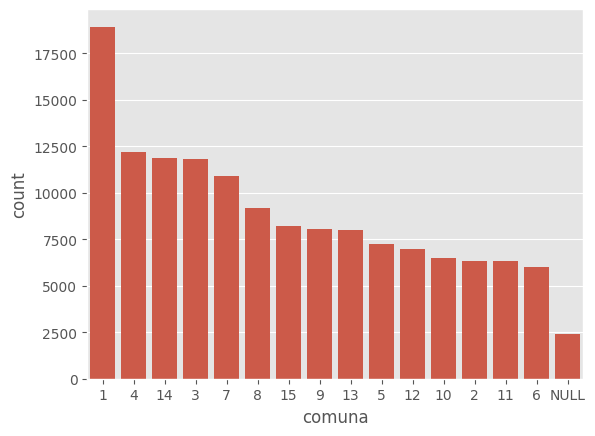

In [ ]:
sns.barplot(x=data.comuna.value_counts().index, y=data.comuna.value_counts())

<Axes: ylabel='count'>

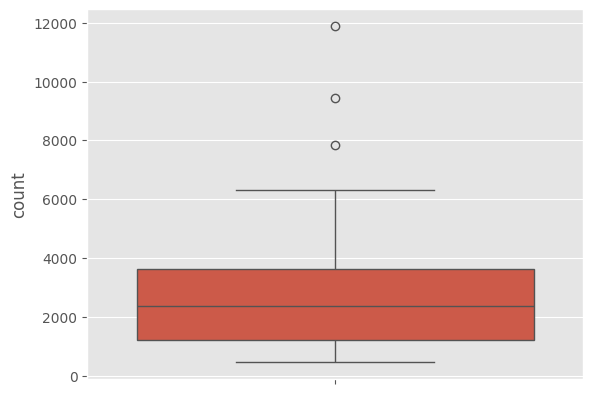

In [ ]:
sns.boxplot(data.barrio.value_counts())

**Tipo de Delito**

In [ ]:

# En porcentaje
data.tipo.value_counts()

tipo
Robo          56334
Hurto         54304
Vialidad      10181
Lesiones      10153
Amenazas       9857
Homicidios       89
Name: count, dtype: int64

In [ ]:
data

,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,geo
0,2022,OCTUBRE,VIERNES,2022-10-14,3,Robo,Robo total,NO,NO,CHACARITA,15,"-34.584136,-58.454704"
1,2022,OCTUBRE,JUEVES,2022-10-27,5,Robo,Robo total,NO,NO,BARRACAS,4,"-34.645043,-58.373194"
2,2022,NOVIEMBRE,MARTES,2022-11-29,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.589982,-58.446471"
3,2022,NOVIEMBRE,LUNES,2022-11-28,0,Robo,Robo total,NO,NO,CHACARITA,15,"-34.58832,-58.441232"
4,2022,NOVIEMBRE,MIERCOLES,2022-11-30,3,Robo,Robo total,NO,NO,RECOLETA,2,"-34.596748,-58.413609"
...,...,...,...,...,...,...,...,...,...,...,...,...
140913,2022,DICIEMBRE,JUEVES,2022-12-15,19,Vialidad,Muertes por siniestros viales,NO,NO,CHACARITA,15,"-34.585065,-58.459021"
140914,2022,DICIEMBRE,VIERNES,2022-12-16,13,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.63524,-58.487609"
140915,2022,DICIEMBRE,JUEVES,2022-12-22,11,Vialidad,Muertes por siniestros viales,NO,NO,VELEZ SARSFIELD,10,"-34.638974,-58.482881"
140916,2022,DICIEMBRE,VIERNES,2022-12-30,18,Vialidad,Muertes por siniestros viales,NO,NO,PARQUE AVELLANEDA,9,"-34.652681,-58.481979"


# Seccion 4: Feature y Target

In [ ]:
# Importamos Scickit Learn
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse = False)

# Definimos la variable a realizar el onehotencoder
delito = data.tipo.values.reshape(-1,1)

onehot_encoder.fit(delito)

delito_encoded = onehot_encoder.transform(delito)

delito_encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
# Mostramos las categorias que quedaron
onehot_encoder.categories_

[array(['Amenazas', 'Homicidios', 'Hurto', 'Lesiones', 'Robo', 'Vialidad'],
       dtype=object)]

In [ ]:
# Lo agregamos al data set
# Primero armamos un data frame pequeño, con lo que queremos unir
delito_encoded_df = pd.DataFrame(delito_encoded, dtype=int,columns=(['Amenazas','Homicidios', 'Hurto','Lesiones', 'Robo','Vialidad']))

#Le ponemos el mismo indice que el data frame donde queremos agregarlo
delito_encoded_df = delito_encoded_df.set_index(data.index)

delito_df = pd.DataFrame(delito, columns=['tipo'])
#df_delitos = pd.concat([delito, delito_encoded_df], axis=1)

df_delitos = pd.concat([data, delito_encoded_df], axis=1)

#df_delitos = df_delitos.drop(df_delitos[df_delitos['tipo'].isna()].index)
df_delitos = df_delitos.drop(columns=['tipo'])
df_delitos = df_delitos.drop(columns=['subtipo'])
#df_delitos = df_delitos.drop(columns=['delitos_por_comuna_x'])
#df_delitos = df_delitos.drop(columns=['delitos_por_comuna_y'])
df_delitos = df_delitos.drop(columns=['anio'])


df_delitos

,mes,dia,fecha,franja,uso_arma,uso_moto,barrio,comuna,geo,Amenazas,Homicidios,Hurto,Lesiones,Robo,Vialidad
0,OCTUBRE,VIERNES,2022-10-14,3.0,NO,NO,CHACARITA,15.0,"-34.584136,-58.454704",0,0,0,0,1,0
1,OCTUBRE,JUEVES,2022-10-27,5.0,NO,NO,BARRACAS,4.0,"-34.645043,-58.373194",0,0,0,0,1,0
2,NOVIEMBRE,MARTES,2022-11-29,0.0,NO,NO,CHACARITA,15.0,"-34.589982,-58.446471",0,0,0,0,1,0
3,NOVIEMBRE,LUNES,2022-11-28,0.0,NO,NO,CHACARITA,15.0,"-34.58832,-58.441232",0,0,0,0,1,0
4,NOVIEMBRE,MIERCOLES,2022-11-30,3.0,NO,NO,RECOLETA,2.0,"-34.596748,-58.413609",0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140913,DICIEMBRE,JUEVES,2022-12-15,19.0,NO,NO,CHACARITA,15.0,"-34.585065,-58.459021",0,0,0,0,0,1
140914,DICIEMBRE,VIERNES,2022-12-16,13.0,NO,NO,VELEZ SARSFIELD,10.0,"-34.63524,-58.487609",0,0,0,0,0,1
140915,DICIEMBRE,JUEVES,2022-12-22,11.0,NO,NO,VELEZ SARSFIELD,10.0,"-34.638974,-58.482881",0,0,0,0,0,1
140916,DICIEMBRE,VIERNES,2022-12-30,18.0,NO,NO,PARQUE AVELLANEDA,9.0,"-34.652681,-58.481979",0,0,0,0,0,1


In [ ]:
dict_variables = dict(zip('lmnopqrstuvwxz',list(df_delitos.columns)))
dict_variables

#i, j, k
l = 'mes'
m = 'dia'
n = 'fecha'
o = 'franja'
p = 'uso_arma'
q = 'uso_moto'
r ='barrio'
s= 'comuna'
t= 'geo'
u= 'Amenazas'
v= 'Homicidio'
w= 'Hurto'
x= 'Lesiones'
y= 'Robo'
z= 'Vialidad'

# Seccion 5: Modelo de Regresion Logistico

In [ ]:
# @title División de datos Entrenamiento/Test Caso una sola variable
variable_feature = s # @param  {allow-input: true}
variable_target = y # @param  {allow-input: true}
# tomamos una sola variable caso 1

X = df_delitos[[variable_feature]]
Y = df_delitos[variable_target]

X_train, X_test, Y_train, Y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        Y.values.reshape(-1,1),
                                        train_size   = 0.80,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

dict_div_data = {f'Cantidad de Train': [len(X_train), len(Y_train)],
f'Cantidad de Test': [len(X_test), len(Y_test)]}
df_div_data = pd.DataFrame.from_dict(dict_div_data, orient='index', columns=[variable_feature,variable_target])
df_div_data

,comuna,Robo
Cantidad de Train,110820,110820
Cantidad de Test,27705,27705


In [ ]:
# @title Creación del modelo scikit learn
# ==============================================================================
modelo = LogisticRegression()
modelo.fit(X = X_train, y = Y_train)

LogisticRegression()

In [ ]:
# @title Valores para el modelo

#!pip install sklearn
import sklearn.metrics

dict_esta_modelo= {'punto de corte/intercerto ' : [modelo.intercept_][0],
'pendiente/coeficiente ' : [modelo.coef_[0][0]],
'Bondad de ajuste' : [ modelo.score(X, Y.to_frame().values.reshape(-1,1))]}
df_esta_modelo = pd.DataFrame.from_dict(dict_esta_modelo, orient='index',columns=[f'Valores para {variable_feature}'])
df_esta_modelo

,Valores para comuna
punto de corte/intercerto,-0.253051
pendiente/coeficiente,-0.017254
Bondad de ajuste,0.594918


In [ ]:
# @title Valores importantes para la predicción del modelo

Y_pred = modelo.predict(X_test)
dict_errores_datos = {'Error cuadratico medio (MSE)' : [mean_squared_error(Y_test, Y_pred)],
'Error absoluto medio (MAE)' : [mean_absolute_error(Y_test, Y_pred)],
'Error máximo (M)' : [max_error(Y_test, Y_pred)],
'Suma de residuos al cuadrado (RSS)' : [mean_squared_error(Y_test, Y_pred)*len(Y_pred)],
'Raiz cuadrada del error cuadratico medio (RMSE)' : [mean_squared_error(Y_test, Y_pred,squared=False)],
'Probabilidad de acierto' : [modelo.score(Y_test, Y_pred)]}
df_errores_datos = pd.DataFrame.from_dict(dict_errores_datos, orient='index',columns=[f'Valores para {variable_feature}'])
df_errores_datos

,Valores para comuna
Error cuadratico medio (MSE),0.400686
Error absoluto medio (MAE),0.400686
Error máximo (M),1.000000
Suma de residuos al cuadrado (RSS),11101.000000
Raiz cuadrada del error cuadratico medio (RMSE),0.632997
Probabilidad de acierto,1.000000


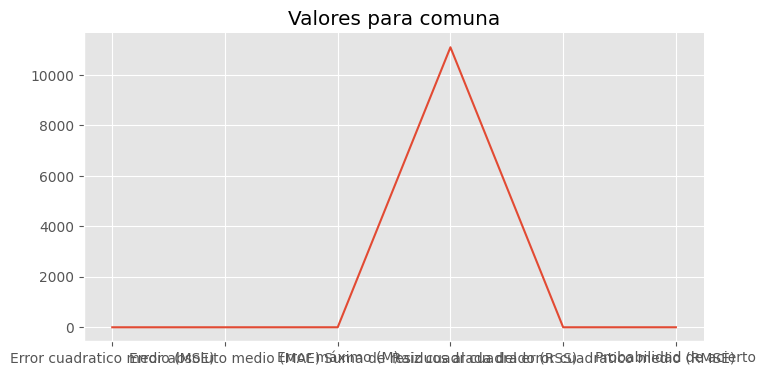

In [ ]:
# @title Valores para comuna

from matplotlib import pyplot as plt
df_errores_datos['Valores para comuna'].plot(kind='line', figsize=(8, 4), title='Valores para comuna')

plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# @title Creación del modelo statsmodels

X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=Y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.674683
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               110820
Model:                          Logit   Df Residuals:                   110818
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Jul 2024   Pseudo R-squ.:                0.001119
Time:                        23:05:04   Log-Likelihood:                -74768.
converged:                       True   LL-Null:                       -74852.
Covariance Type:            nonrobust   LLR p-value:                 2.564e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2531      0.012    -21.973      0.000      -0.276      -0.230
x1            -0.0173      0.

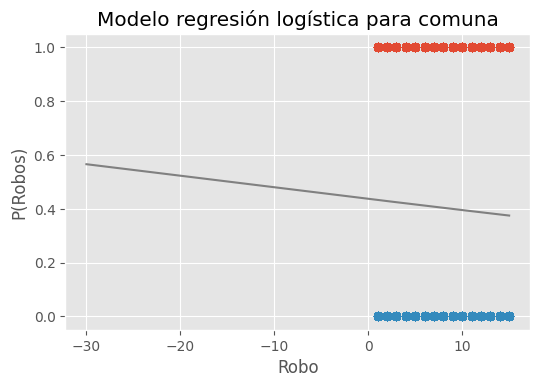

In [ ]:
# @title Gráfico del modelo
# ==============================================================================
grid_X = np.linspace(
            start = -30,
            stop  = max(df_delitos[variable_feature]),
            num   = 200
         ).reshape(-1,1)

grid_X = sm.add_constant(grid_X, prepend=True)
Y_pred_mod = modelo.predict(exog = grid_X)

fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(
    X_train[(Y_train == 1).flatten(), 1],
    Y_train[(Y_train == 1).flatten()].flatten()
)
ax.scatter(
    X_train[(Y_train == 0).flatten(), 1],
    Y_train[(Y_train == 0).flatten()].flatten()
)
ax.plot(grid_X[:, 1], Y_pred_mod, color = "gray")
ax.set_title(f"Modelo regresión logística para {variable_feature}")
ax.set_ylabel("P(Robos)")
ax.set_xlabel(f"{y}");

# Conclusiones

Nuestro modelo de Regresión Logística, no muestra la curva de una función sigmoide, por ende no se está cumpliendo las características del modelo.
Las variables tienen una alta correlación.

Tenemos un RMSE: 0.63
y una Bondad de ajuste: 0.59

Que son bajas para considerar este modelo viable.

# Recomendaciones

Por este motivo no podemos recomendar la utilización de este modelo de Regresión Logística, para futuros análisis del dataset del delito en CABA.

Hasta que realicemos las pruebas suficientes para poder mejorar dicho modelo en el futuro